## Imports

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from function import Eddies_Tools
import numpy as np

from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler

## EDA/Cleaning

In [6]:
trade_chat = pd.read_csv('data\\trade_chat_v3.csv', index_col=0)

In [7]:
trade_chat 

,date,time,text,sentiment,target
0,2/22/2022,8:14:35 AM,how long will downtime be,Other,Patch
1,2/22/2022,8:14:40 AM,8 hours,Other,Patch
2,2/22/2022,8:14:42 AM,few hours,Other,Patch
3,2/22/2022,8:14:42 AM,8 hours?,Negative,Patch
4,2/22/2022,8:14:42 AM,7hrs,Other,Patch
...,...,...,...,...,...
4444,2/23/2022,10:21:11 PM,WTS +15 With my team 2500 io Timed!,Other,Boost
4445,2/23/2022,10:21:45 PM,<Guild Offering> CHEAPEST Mythic/Heroic [Sanc...,Other,Boost
2717,2/23/2022,2:49:47 PM,heroic also so I don't screw up your count,Other,Chat
4447,2/23/2022,10:23:12 PM,wts Strange Goop 250k no need of ah get it ch...,Other,Trade


In [8]:
trade_chat.target.value_counts()

Chat     992
Boost    750
Patch    713
LFM      688
Game     640
Trade    484
LFG      150
Bug       32
Name: target, dtype: int64

In [9]:
trade_chat.sentiment.value_counts()

Other       3883
Negative     566
Name: sentiment, dtype: int64

In [10]:
trade_chat['text'].duplicated().value_counts()

False    2851
True     1598
Name: text, dtype: int64

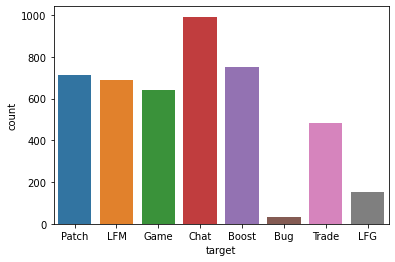

In [11]:
sns.countplot(x='target', data= trade_chat);

In [12]:
trade_chat.drop_duplicates(subset= 'text', inplace=True)
trade_chat.reset_index(drop=True, inplace=True)

In [13]:
trade_chat['text'].duplicated().value_counts()

False    2851
Name: text, dtype: int64

<AxesSubplot:xlabel='target', ylabel='count'>

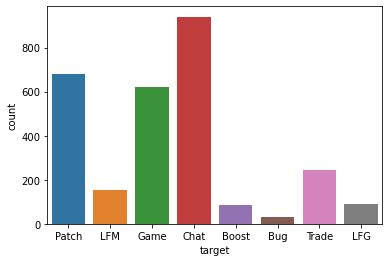

In [14]:
sns.countplot(x='target', data= trade_chat)

In [15]:
patch = trade_chat[trade_chat.target == 'Patch']
chat = trade_chat[trade_chat.target == 'Chat']
game = trade_chat[trade_chat.target == 'Game']

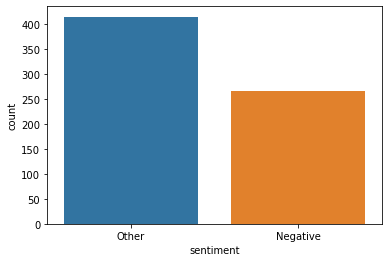

In [16]:
sns.countplot(x='sentiment', data= patch);

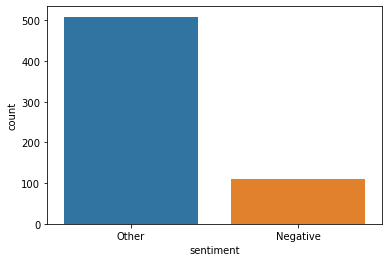

In [17]:
sns.countplot(x='sentiment', data= game);

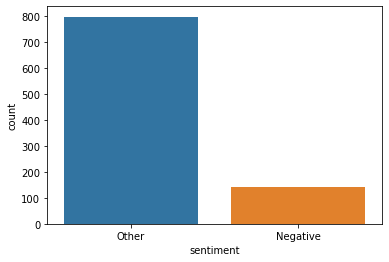

In [18]:
sns.countplot(x='sentiment', data= chat);

In [19]:
patch.sentiment.value_counts()

Other       415
Negative    267
Name: sentiment, dtype: int64

In [20]:
game.sentiment.value_counts()

Other       509
Negative    110
Name: sentiment, dtype: int64

In [21]:
chat.sentiment.value_counts()

Other       799
Negative    141
Name: sentiment, dtype: int64

## NLP

In [22]:
s_words = stopwords.words('english')
# tokenizer = RegexpTokenizer(r"(?u)\b\w\w+\b")
tokenizer = RegexpTokenizer(r"(?u)\b([a-z]+|9.2)\w*\b")
et = Eddies_Tools()

In [23]:
s_words.append('u')
s_words.append('ur')
s_words.append('im')
s_words.append('dont')
s_words.append('thats')

In [24]:
tc_tokenized = et.nlp_tokenizer(trade_chat, tokenizer, s_words)

In [25]:
tc_tokenized

,date,time,text,sentiment,target,text_tokenized,joined_tokens
0,2/22/2022,8:14:35 AM,how long will downtime be,Other,Patch,"[long, downtime]",long downtime
1,2/22/2022,8:14:40 AM,8 hours,Other,Patch,[hours],hours
2,2/22/2022,8:14:42 AM,few hours,Other,Patch,[hours],hours
3,2/22/2022,8:14:42 AM,8 hours?,Negative,Patch,[hours],hours
4,2/22/2022,8:14:42 AM,7hrs,Other,Patch,[other],other
...,...,...,...,...,...,...,...
2846,2/23/2022,10:16:11 PM,lfm antorus first 2 last 2 only,Other,Game,"[lfm, antorus, first, last]",lfm antorus first last
2847,2/23/2022,11:15:51 AM,afternoon,Other,Chat,[afternoon],afternoon
2848,2/23/2022,10:21:11 PM,wts +15 with my team 2500 io timed!,Other,Boost,"[wts, team, io, timed]",wts team io timed
2849,2/23/2022,2:49:47 PM,heroic also so i don't screw up your count,Other,Chat,"[heroic, also, screw, count]",heroic also screw count


In [26]:
counter = 0

for i, lists in enumerate(tc_tokenized.text_tokenized):
    if lists == []:
        counter += 1

counter

0

In [27]:
chat_tokenized = tc_tokenized[tc_tokenized.target == 'Chat']
patch_tokenized = tc_tokenized[tc_tokenized.target == 'Patch']
game_tokenized = tc_tokenized[tc_tokenized.target == 'Game']

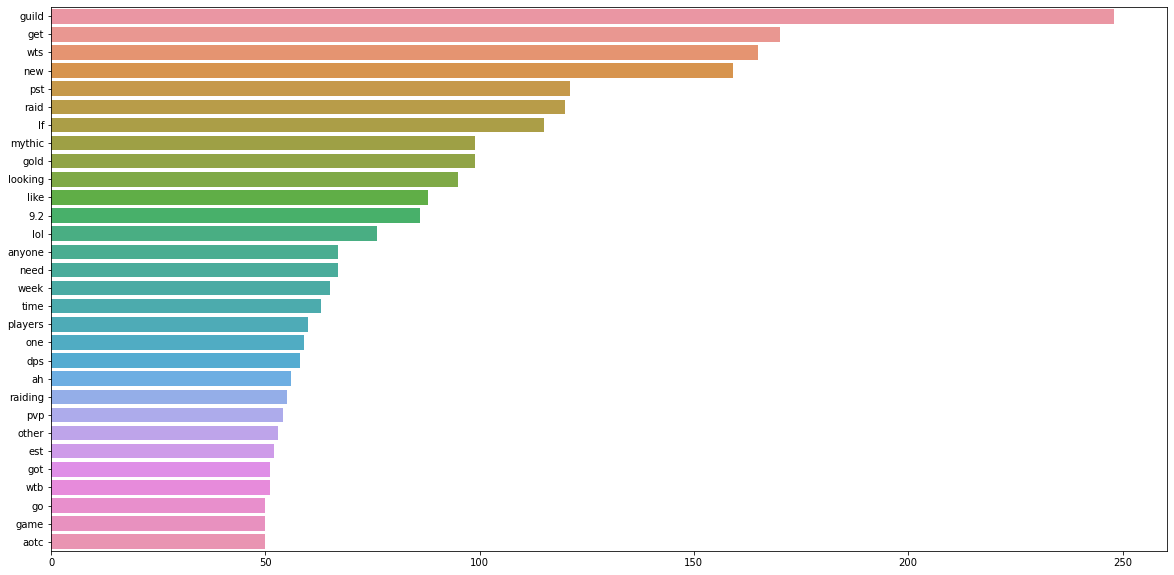

In [28]:
fdist = FreqDist(tc_tokenized.text_tokenized.explode())

top_30_words = list(zip(*fdist.most_common(30)))

tokens = np.array(top_30_words[0])
count = np.array(top_30_words[1])

fig, ax = plt.subplots(figsize=(20,10))

top_30_chart = sns.barplot(x= count, y= tokens)


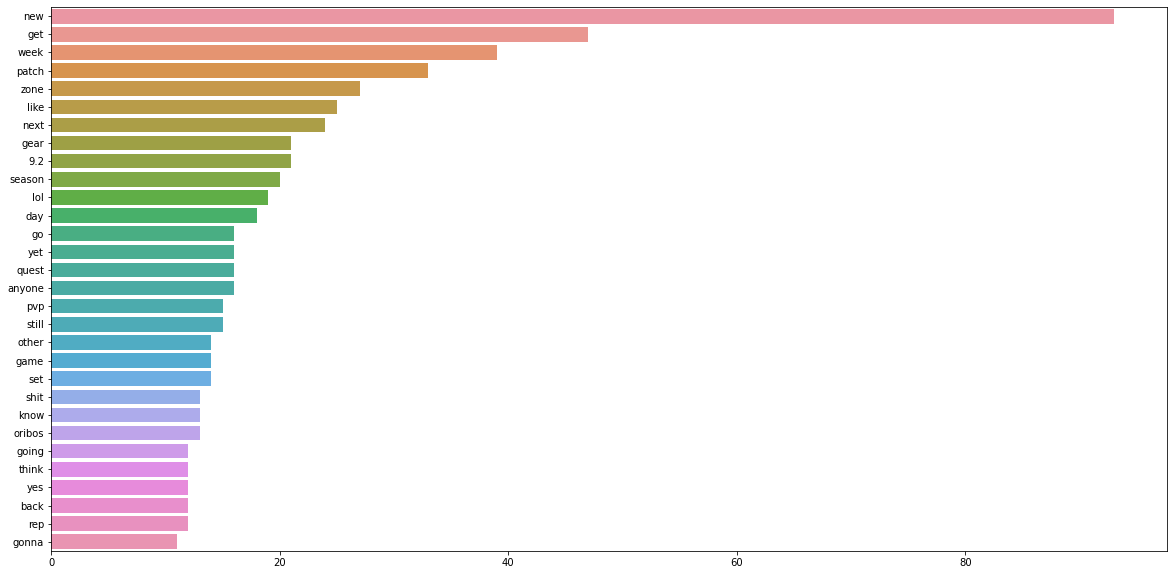

In [29]:
patch_fdist = FreqDist(patch_tokenized.text_tokenized.explode())

top_30_words = list(zip(*patch_fdist.most_common(30)))

tokens = np.array(top_30_words[0])
count = np.array(top_30_words[1])

fig, ax = plt.subplots(figsize=(20,10))

top_30_chart = sns.barplot(x= count, y= tokens)

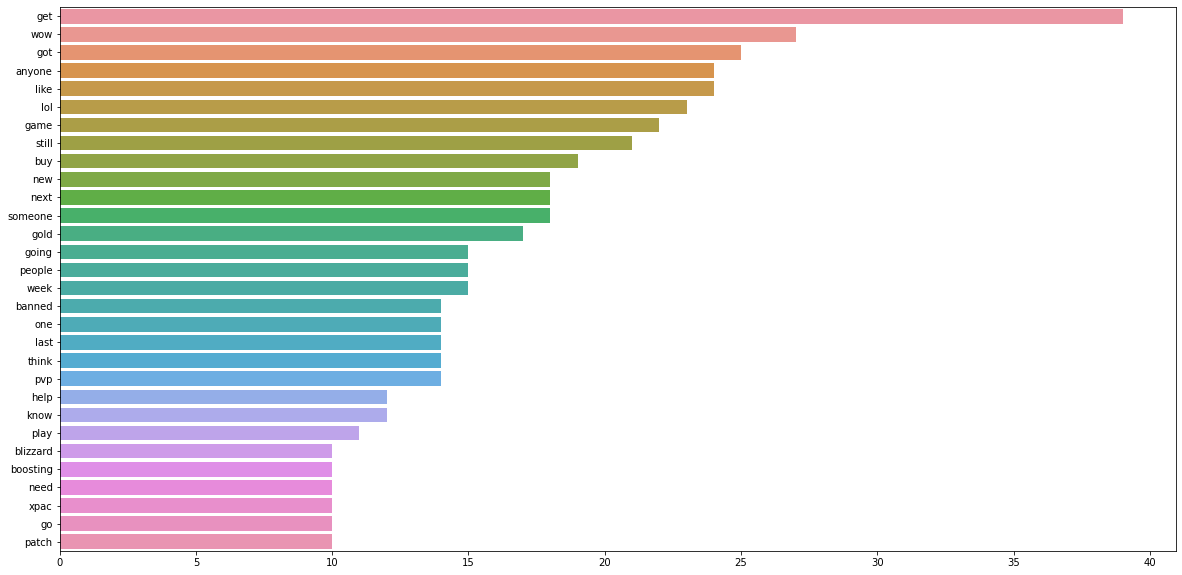

In [30]:
game_fdist = FreqDist(game_tokenized.text_tokenized.explode())

top_30_words = list(zip(*game_fdist.most_common(30)))

tokens = np.array(top_30_words[0])
count = np.array(top_30_words[1])

fig, ax = plt.subplots(figsize=(20,10))

top_30_chart = sns.barplot(x= count, y= tokens)

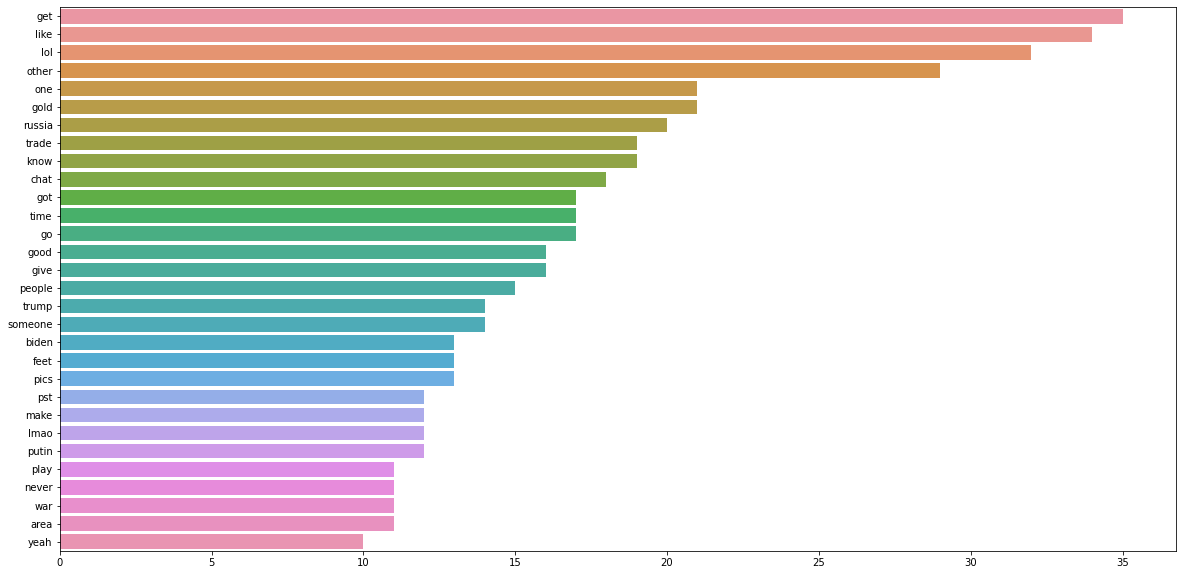

In [31]:
chat_fdist = FreqDist(chat_tokenized.text_tokenized.explode())

top_30_words = list(zip(*chat_fdist.most_common(30)))

tokens = np.array(top_30_words[0])
count = np.array(top_30_words[1])

fig, ax = plt.subplots(figsize=(20,10))

top_30_chart = sns.barplot(x= count, y= tokens)

In [32]:
neg_patch = patch_tokenized[patch_tokenized.sentiment == 'Negative']
neg_chat = chat_tokenized[chat_tokenized.sentiment == 'Negative']
neg_game = game_tokenized[game_tokenized.sentiment == 'Negative']
other_patch = patch_tokenized[patch_tokenized.sentiment == 'Other']
other_chat = chat_tokenized[chat_tokenized.sentiment == 'Other']
other_game = game_tokenized[game_tokenized.sentiment == 'Other']

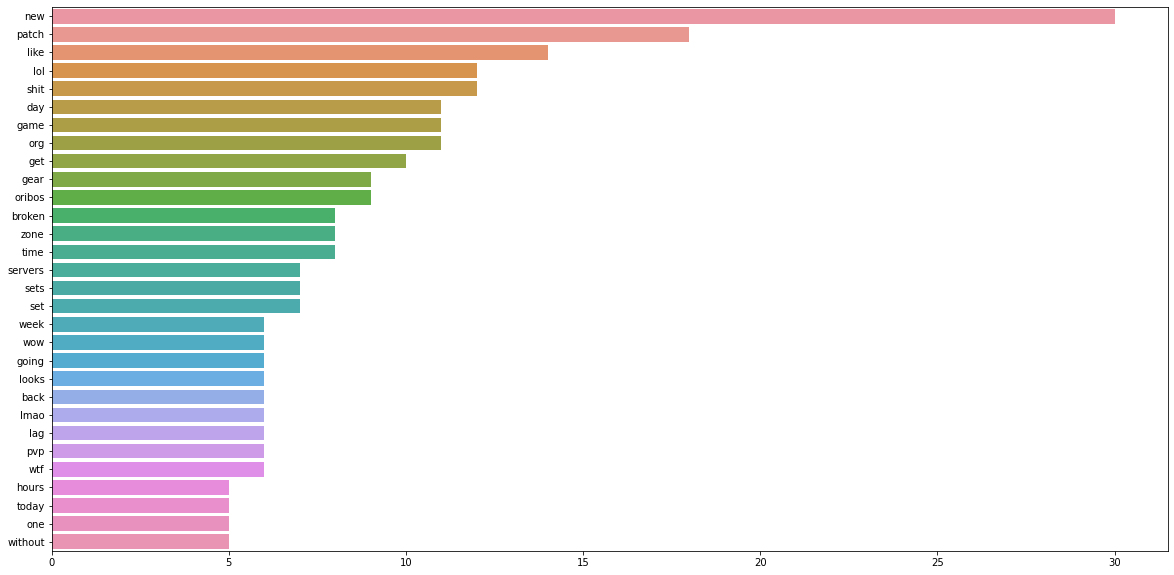

In [33]:
neg_patch_fdist = FreqDist(neg_patch.text_tokenized.explode())

top_30_words = list(zip(*neg_patch_fdist.most_common(30)))

tokens = np.array(top_30_words[0])
count = np.array(top_30_words[1])

fig, ax = plt.subplots(figsize=(20,10))

top_30_chart = sns.barplot(x= count, y= tokens)

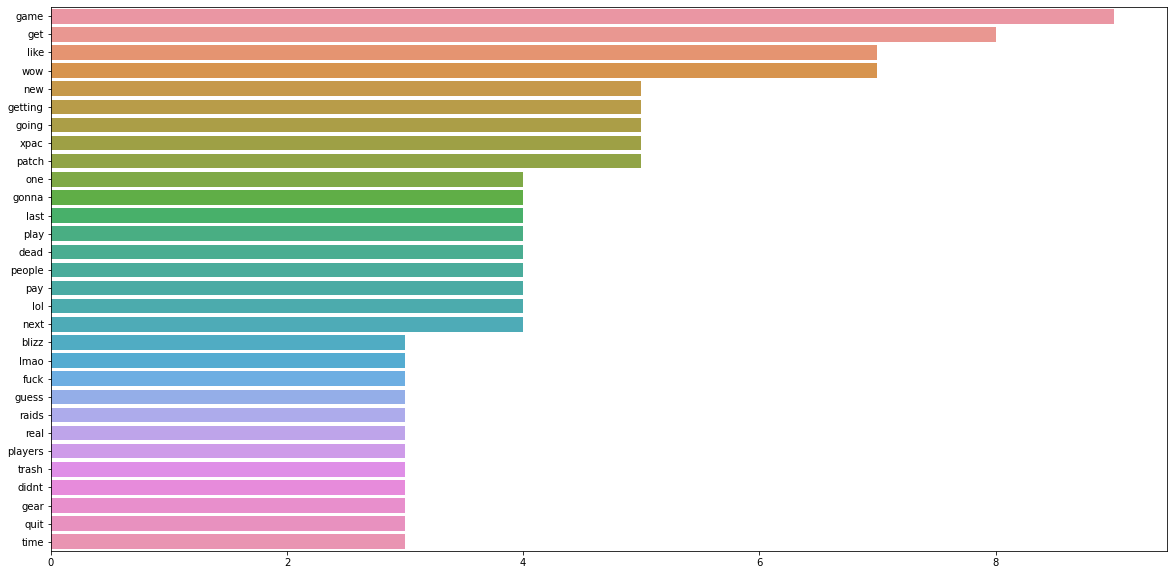

In [34]:
neg_game_fdist = FreqDist(neg_game.text_tokenized.explode())

top_30_words = list(zip(*neg_game_fdist.most_common(30)))

tokens = np.array(top_30_words[0])
count = np.array(top_30_words[1])

fig, ax = plt.subplots(figsize=(20,10))

top_30_chart = sns.barplot(x= count, y= tokens)

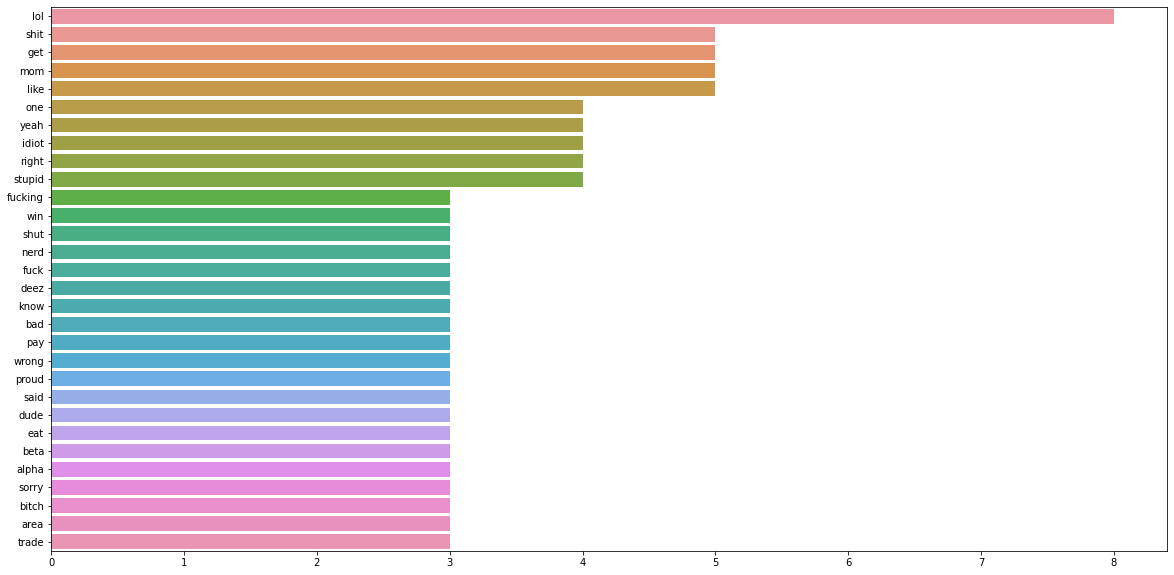

In [35]:
neg_chat_fdist = FreqDist(neg_chat.text_tokenized.explode())

top_30_words = list(zip(*neg_chat_fdist.most_common(30)))

tokens = np.array(top_30_words[0])
count = np.array(top_30_words[1])

fig, ax = plt.subplots(figsize=(20,10))

top_30_chart = sns.barplot(x= count, y= tokens)

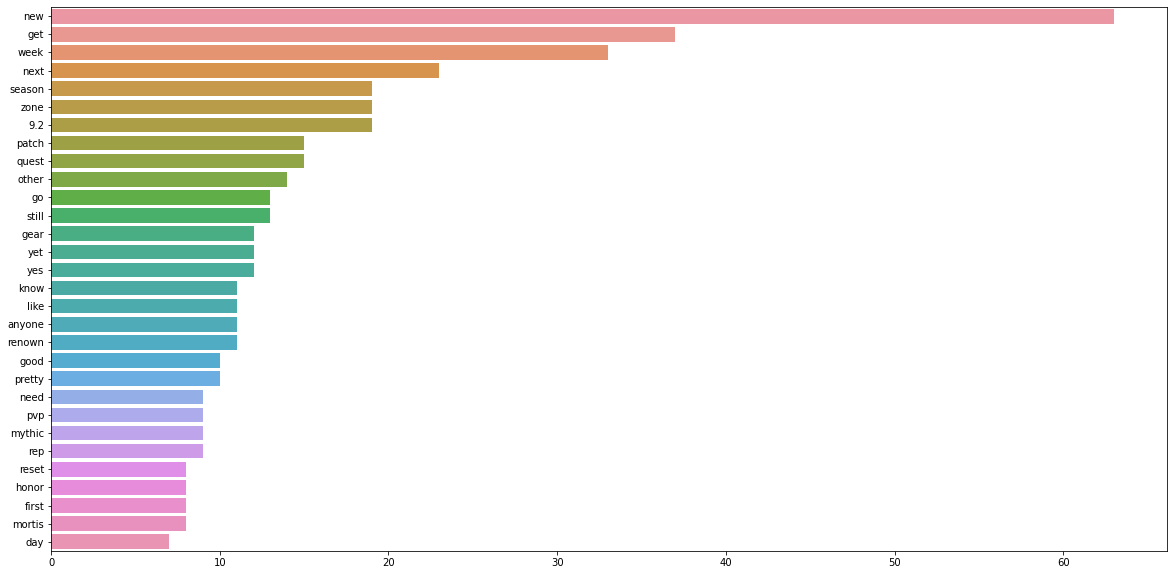

In [36]:
other_patch_fdist = FreqDist(other_patch.text_tokenized.explode())

top_30_words = list(zip(*other_patch_fdist.most_common(30)))

tokens = np.array(top_30_words[0])
count = np.array(top_30_words[1])

fig, ax = plt.subplots(figsize=(20,10))

top_30_chart = sns.barplot(x= count, y= tokens)

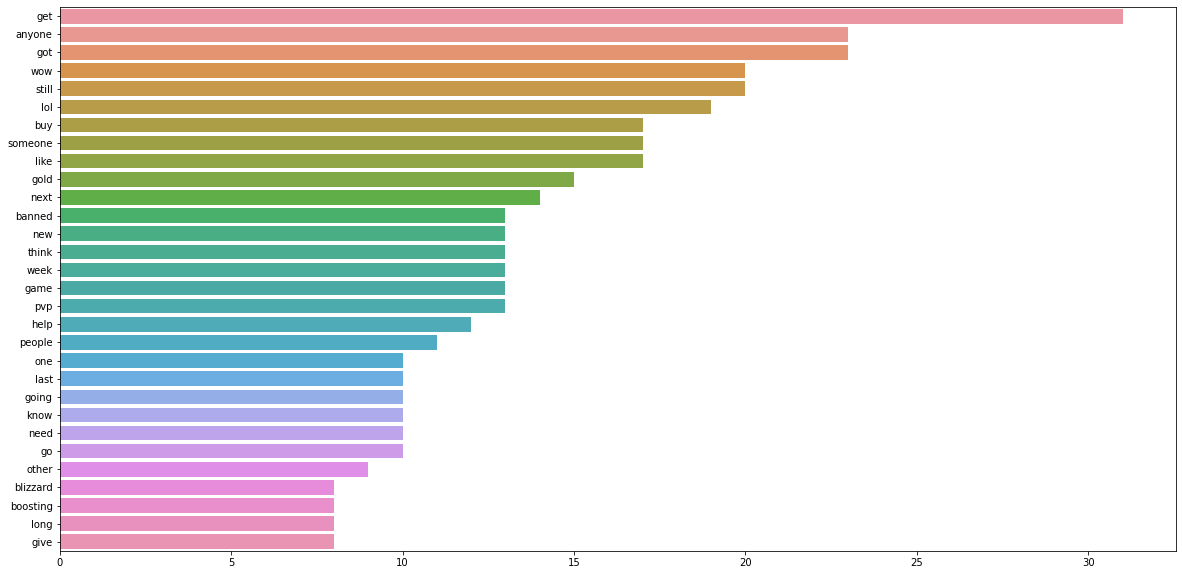

In [37]:
other_game_fdist = FreqDist(other_game.text_tokenized.explode())

top_30_words = list(zip(*other_game_fdist.most_common(30)))

tokens = np.array(top_30_words[0])
count = np.array(top_30_words[1])

fig, ax = plt.subplots(figsize=(20,10))

top_30_chart = sns.barplot(x= count, y= tokens)

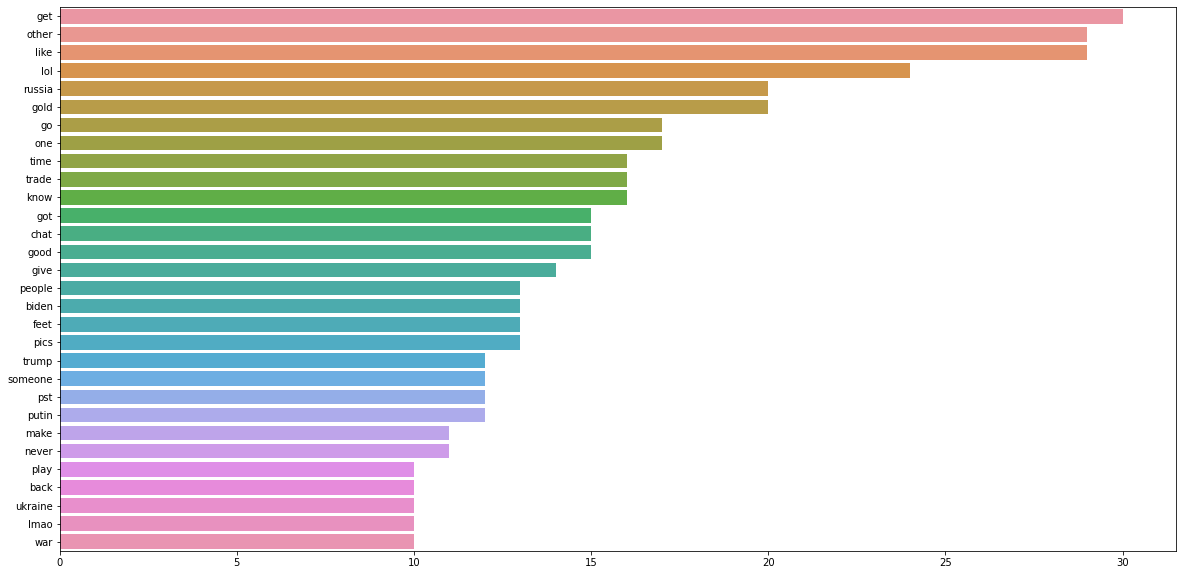

In [38]:
other_chat_fdist = FreqDist(other_chat.text_tokenized.explode())

top_30_words = list(zip(*other_chat_fdist.most_common(30)))

tokens = np.array(top_30_words[0])
count = np.array(top_30_words[1])

fig, ax = plt.subplots(figsize=(20,10))

top_30_chart = sns.barplot(x= count, y= tokens)

## Data Shaping

In [39]:
tc_simple = tc_tokenized.copy()

In [40]:
tc_simple.target.value_counts()

Chat     940
Patch    682
Game     619
Trade    246
LFM      154
LFG       91
Boost     87
Bug       32
Name: target, dtype: int64

In [41]:
tc_simple.target.mask(tc_simple.target.isin(['Boost', 'LFG','LFM','Trade']),'Service',inplace=True)

In [42]:
tc_simple.target.mask(tc_simple.target.isin(['Game', 'Patch','Bug']),'Game',inplace=True)

In [43]:
tc_simple.target.value_counts()

Game       1333
Chat        940
Service     578
Name: target, dtype: int64

In [45]:
copy_tc_df = tc_tokenized.copy()

undersampled_df = et.down_sample(copy_tc_df,'sentiment')

In [46]:
undersampled_df.sentiment.value_counts()

Other       545
Negative    545
Name: sentiment, dtype: int64

## Baseline Models

Base dataframe

In [66]:
X = tc_tokenized['joined_tokens']
y_sentiment = tc_tokenized.sentiment.replace(['Negative','Other'],[1,0])
y_target = tc_tokenized['target']

In [101]:
tc_tokenized.sentiment.value_counts()

Other       2306
Negative     545
Name: sentiment, dtype: int64

In [102]:
y_sentiment.value_counts()

0    2306
1     545
Name: sentiment, dtype: int64

Simple Target Tags

In [282]:
X = tc_simple['joined_tokens']
y_sentiment = tc_simple['sentiment']
y_target = tc_simple['target']

Undersampled Sentiment Tags

In [71]:
X = undersampled_df['joined_tokens']
y_sentiment = undersampled_df.sentiment.replace(['Negative','Other'],[1,0])
y_target = undersampled_df['target']

In [72]:
y_sentiment

0       1
1       1
2       1
3       1
4       1
       ..
1085    0
1086    0
1087    0
1088    0
1089    0
Name: sentiment, Length: 1090, dtype: int64

### Sentiment Models

In [114]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y_sentiment, test_size= 0.25, random_state=5)

In [115]:
y_test_s.value_counts()

0    138
1    135
Name: sentiment, dtype: int64

In [116]:
y_test_s.value_counts(normalize=True)

0    0.505495
1    0.494505
Name: sentiment, dtype: float64

In [56]:
s_labels = ['0', '1']

In [51]:
sentiment_models = {}

#### SENTIMENT - Stochastic Gradient Descent Model

In [52]:
sgd_sentiment = Pipeline([('vect', CountVectorizer()), 
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier(random_state=5)),
              ])

cv_mean, accuracy, y_pred, sgd_sentiment = et.run_model(X, y_sentiment, sgd_sentiment)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

sentiment_models['SGD'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}


CV Mean: 0.6683
Accuracy: 0.6703


In [55]:
print(classification_report(y_test_s, y_pred, target_names=s_labels))

              precision    recall  f1-score   support

    Negative       0.68      0.63      0.65       135
       Other       0.66      0.71      0.69       138

    accuracy                           0.67       273
   macro avg       0.67      0.67      0.67       273
weighted avg       0.67      0.67      0.67       273



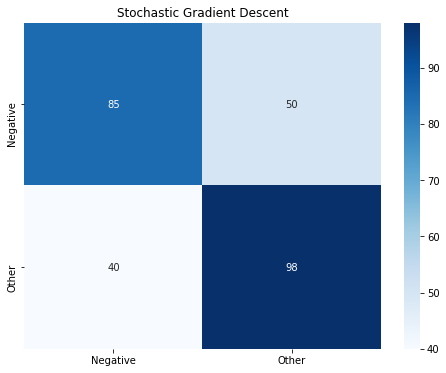

In [53]:
cm = confusion_matrix(y_test_s, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=s_labels, yticklabels=s_labels)
ax.set_title('Stochastic Gradient Descent');

#### SENTIMENT - Random Forest Model

In [177]:
rfc_sentiment = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(random_state=5)),
              ])

cv_mean, accuracy, y_pred, rfc_sentiment = et.run_model(X, y_sentiment, rfc_sentiment)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

sentiment_models['RFC'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}


CV Mean: 0.8204
Accuracy: 0.8219


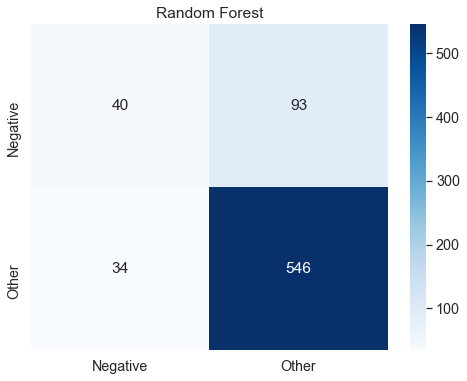

In [178]:
cm = confusion_matrix(y_test_s, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=s_labels, yticklabels=s_labels)
ax.set_title('Random Forest');

#### SENTIMENT - Naive Bayes Model

In [179]:
naive_sentiment = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

cv_mean, accuracy, y_pred, naive_sentiment = et.run_model(X, y_sentiment, naive_sentiment)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

sentiment_models['Naive'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}


CV Mean: 0.8157
Accuracy: 0.8247


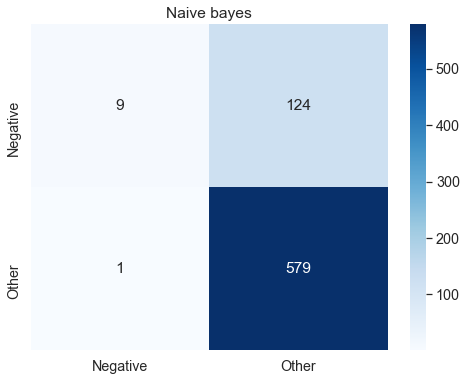

In [180]:
cm = confusion_matrix(y_test_s, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=s_labels, yticklabels=s_labels)
ax.set_title('Naive bayes');

#### SENTIMENT - Logistic Regression Model

In [183]:
lg_sentiment = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression(random_state=5)),
              ])

cv_mean, accuracy, y_pred, lg_sentiment = et.run_model(X, y_sentiment, lg_sentiment)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

sentiment_models['LogReg'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}


CV Mean: 0.8171
Accuracy: 0.8177


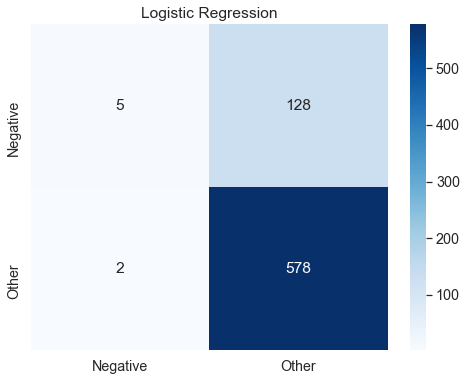

In [184]:
cm = confusion_matrix(y_test_s, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=s_labels, yticklabels=s_labels)
ax.set_title('Logistic Regression');

#### SENTIMENT - SVC Model

In [185]:
svc_sentiment = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', SVC(random_state=5)),
              ])

cv_mean, accuracy, y_pred, svc_sentiment = et.run_model(X, y_sentiment, svc_sentiment)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

sentiment_models['SVC'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}

CV Mean: 0.8195
Accuracy: 0.8163


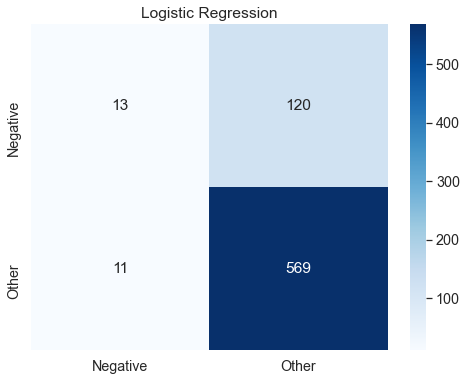

In [186]:
cm = confusion_matrix(y_test_s, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=s_labels, yticklabels=s_labels)
ax.set_title('Logistic Regression');

In [161]:
sentiment_models

{'SGD': {'CV Mean': 0.7942, 'Accuracy': 0.805},
 'RFC': {'CV Mean': 0.8204, 'Accuracy': 0.8219},
 'Naive': {'CV Mean': 0.8157, 'Accuracy': 0.8247},
 'LogReg': {'CV Mean': 0.8171, 'Accuracy': 0.8177},
 'SVC': {'CV Mean': 0.8195, 'Accuracy': 0.8163}}

### Target Models

In [283]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y_target, test_size= 0.25, random_state=5)

In [284]:
target_models = {}

In [285]:
y_test_t.value_counts()

Game       327
Chat       245
Service    141
Name: target, dtype: int64

In [286]:
t_labels = sorted(list(tc_tokenized.target.value_counts().index))

In [289]:
t_labels = sorted(list(tc_simple.target.value_counts().index))

#### TARGET - Stochastic Gradient Descent Model

In [290]:
sgd_target = Pipeline([('vect', CountVectorizer()), 
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier(random_state=5)),
              ])

cv_mean, accuracy, y_pred, sgd_target = et.run_model(X, y_target, sgd_target)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

target_models['SGD'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}



CV Mean: 0.7119
Accuracy: 0.7504


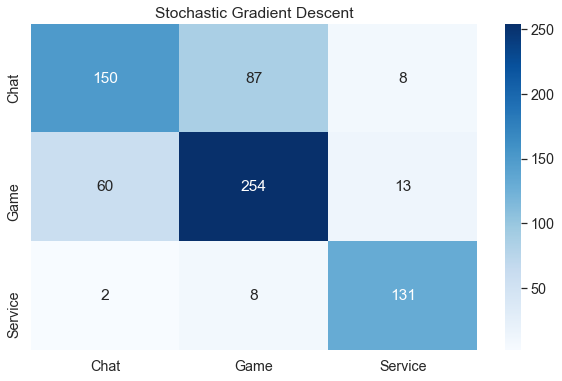

In [291]:
cm = confusion_matrix(y_test_t, y_pred)

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=t_labels, yticklabels=t_labels)
ax.set_title('Stochastic Gradient Descent');

#### TARGET - Random Forest Model

In [292]:
rfc_target = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(random_state=5)),
              ])

cv_mean, accuracy, y_pred, rfc_target = et.run_model(X, y_target, rfc_target)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

target_models['RFC'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}


CV Mean: 0.7203
Accuracy: 0.7433


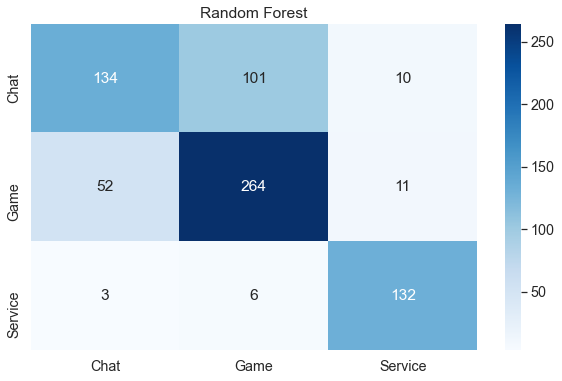

In [293]:
cm = confusion_matrix(y_test_t, y_pred)

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=t_labels, yticklabels=t_labels)
ax.set_title('Random Forest');

#### TARGET - Naive Bayes Model

In [294]:
naive_target = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

cv_mean, accuracy, y_pred, naive_target = et.run_model(X, y_target, naive_target)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

target_models['Naive'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}

CV Mean: 0.7142
Accuracy: 0.7377


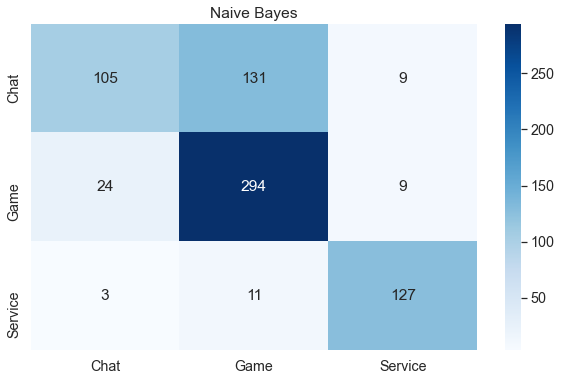

In [295]:
cm = confusion_matrix(y_test_t, y_pred)

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=t_labels, yticklabels=t_labels)
ax.set_title('Naive Bayes');

#### TARGET - Logistic Regression Model

In [296]:
lg_target = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression(random_state=5)),
              ])

cv_mean, accuracy, y_pred, lg_target = et.run_model(X, y_target, lg_target)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

target_models['LogReg'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}

CV Mean: 0.717
Accuracy: 0.7447


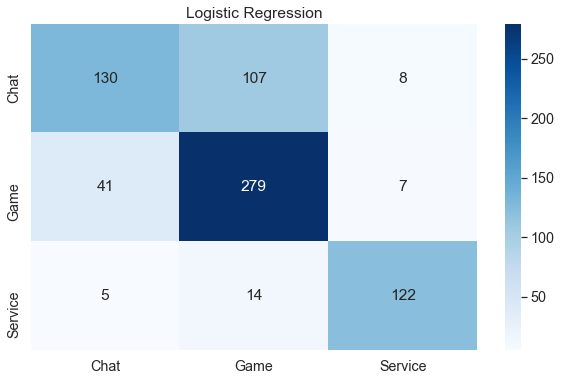

In [297]:
cm = confusion_matrix(y_test_t, y_pred)

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=t_labels, yticklabels=t_labels)
ax.set_title('Logistic Regression');

#### TARGET - SVC Model

In [298]:
svc_target = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', SVC(random_state=5)),
              ])

cv_mean, accuracy, y_pred, svc_target = et.run_model(X, y_target, svc_target)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

target_models['SVC'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}

CV Mean: 0.7292
Accuracy: 0.7335


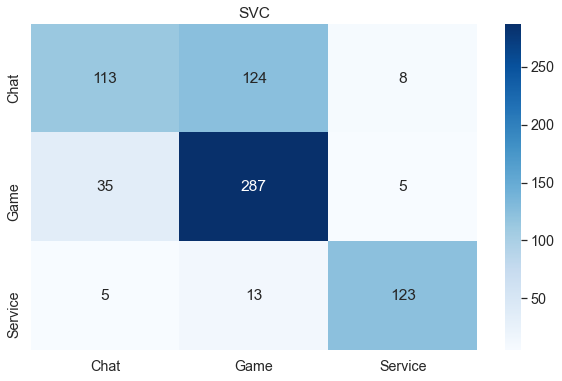

In [299]:
cm = confusion_matrix(y_test_t, y_pred)

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=t_labels, yticklabels=t_labels)
ax.set_title('SVC');

In [300]:
target_models

{'SGD': {'CV Mean': 0.7119, 'Accuracy': 0.7504},
 'RFC': {'CV Mean': 0.7203, 'Accuracy': 0.7433},
 'Naive': {'CV Mean': 0.7142, 'Accuracy': 0.7377},
 'LogReg': {'CV Mean': 0.717, 'Accuracy': 0.7447},
 'SVC': {'CV Mean': 0.7292, 'Accuracy': 0.7335}}

### Base Model Performance

In [204]:
s_model_df = pd.DataFrame()
s_bmp_labels = list(sentiment_models.keys())

In [205]:
model_list = []
cv_list = []
acc_list = []

for model_name in s_bmp_labels:
    cv_list.append(list(sentiment_models[model_name].values())[0])
    acc_list.append(list(sentiment_models[model_name].values())[1])

s_model_df['model'] = sentiment_models.keys()
s_model_df['cv_mean'] = cv_list
s_model_df['accuracy'] = acc_list

s_model_df


,model,cv_mean,accuracy
0,SGD,0.7942,0.8050
1,RFC,0.8204,0.8219
2,Naive,0.8157,0.8247
3,LogReg,0.8171,0.8177
4,SVC,0.8195,0.8163


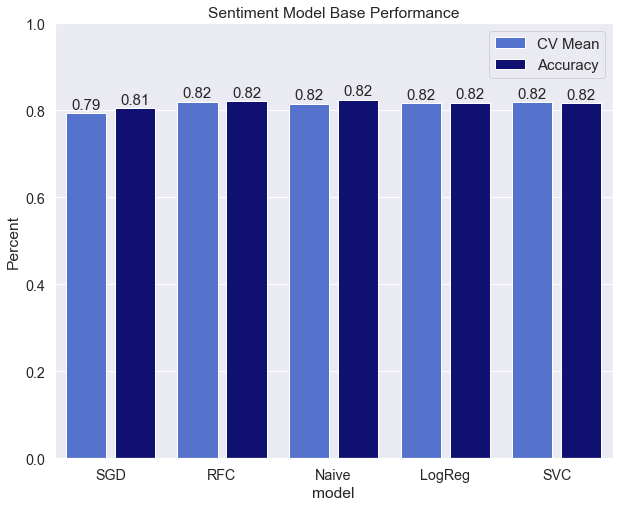

In [207]:
fig, ax = plt.subplots(figsize=(10,8))
width = .45
sns.set(font_scale = 1.3)

ax1 = sns.barplot(x='model', y='cv_mean', data=s_model_df, color='royalblue', label='CV Mean')

for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width)



ax2 = sns.barplot(x='model', y='accuracy', data=s_model_df, color='navy', label='Accuracy')

for bar in ax.containers[1]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width))
    bar.set_width(w * width)

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

ax.set_ylabel('Percent')
ax.set_ybound(upper= 1)
ax.legend(fontsize= 15)
ax.set_title('Sentiment Model Base Performance')


plt.show()

In [301]:
t_model_df = pd.DataFrame()
t_bmp_labels = list(target_models.keys())

In [302]:
model_list = []
cv_list = []
acc_list = []

for model_name in t_bmp_labels:
    cv_list.append(list(target_models[model_name].values())[0])
    acc_list.append(list(target_models[model_name].values())[1])

t_model_df['model'] = target_models.keys()
t_model_df['cv_mean'] = cv_list
t_model_df['accuracy'] = acc_list

t_model_df

,model,cv_mean,accuracy
0,SGD,0.7119,0.7504
1,RFC,0.7203,0.7433
2,Naive,0.7142,0.7377
3,LogReg,0.7170,0.7447
4,SVC,0.7292,0.7335


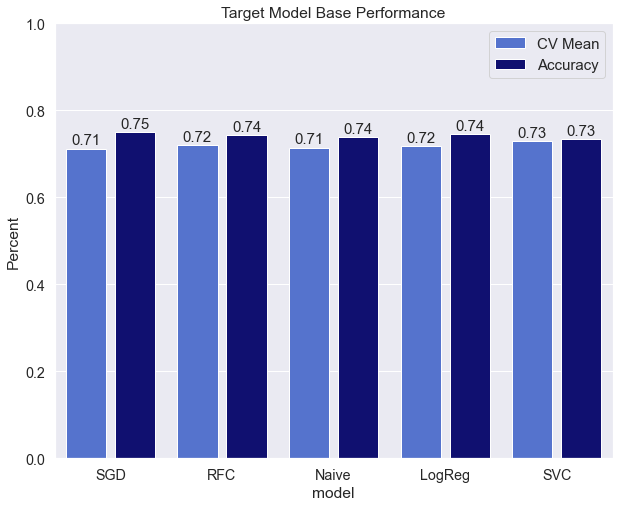

In [303]:
fig, ax = plt.subplots(figsize=(10,8))
width = .45
sns.set(font_scale = 1.3)

ax1 = sns.barplot(x='model', y='cv_mean', data=t_model_df, color='royalblue', label='CV Mean')

for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width)



ax2 = sns.barplot(x='model', y='accuracy', data=t_model_df, color='navy', label='Accuracy')

for bar in ax.containers[1]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width))
    bar.set_width(w * width)

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

ax.set_ylabel('Percent')
ax.set_ybound(upper= 1)
ax.legend(fontsize= 15)
ax.set_title('Target Model Base Performance')


plt.show()

## Tuned Models

### Sentiment Models

In [75]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y_sentiment, test_size= 0.25, random_state=5)

In [50]:
sentiment_models_t = {}

#### Stochastic Gradient Descent Model

In [119]:
sgd_sentiment = Pipeline([('vect', CountVectorizer()), 
                ('tfidf', TfidfTransformer()),
                ('sgd', SGDClassifier(random_state=5)),
               ])

sgd_sentiment.fit(X_train_s, y_train_s)

sgd_params = {
    'vect__strip_accents':[None,'ascii','unicode'],
    'vect__lowercase': [True, False],
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__smooth_idf': [True, False],
    'sgd__loss': ['hinge','log','modified_huber','squared_hinge'],
    'sgd__max_iter':[1000,2000],
    'sgd__class_weight': [None, 'balanced']
}

sgd_gs = GridSearchCV(sgd_sentiment,param_grid=sgd_params, cv=5, verbose=1, n_jobs=-3, scoring='recall')

sgd_gs = sgd_gs.fit(X_train_s, y_train_s)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-3)]: Done 1100 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-3)]: Done 2861 out of 2880 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=-3)]: Done 2880 out of 2880 | elapsed:   10.5s finished


In [120]:
sgd_gs.best_score_

0.9634146341463413

In [121]:
sgd_gs.best_params_

{'sgd__class_weight': None,
 'sgd__loss': 'log',
 'sgd__max_iter': 1000,
 'tfidf__smooth_idf': True,
 'vect__lowercase': True,
 'vect__ngram_range': (2, 2),
 'vect__strip_accents': None}

In [95]:
sgd_sentiment = Pipeline([('vect', CountVectorizer(ngram_range= (1,2))), 
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier(loss = 'log', random_state=5)),
              ])

cv_mean, accuracy, y_pred, sgd_sentiment = et.run_model(X, y_sentiment, sgd_sentiment)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

sentiment_models_t['SGD'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}


CV Mean: 0.6597
Accuracy: 0.6777


In [100]:
cross_val_score(sgd_sentiment, X_train_s, y_train_s, cv= 5, scoring='recall').mean()

0.7195121951219512

In [91]:
print(classification_report(y_test_s, y_pred, target_names=s_labels))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73       138
           1       0.75      0.60      0.67       135

    accuracy                           0.70       273
   macro avg       0.71      0.70      0.70       273
weighted avg       0.71      0.70      0.70       273



In [88]:
y_test_s.value_counts()

0    138
1    135
Name: sentiment, dtype: int64

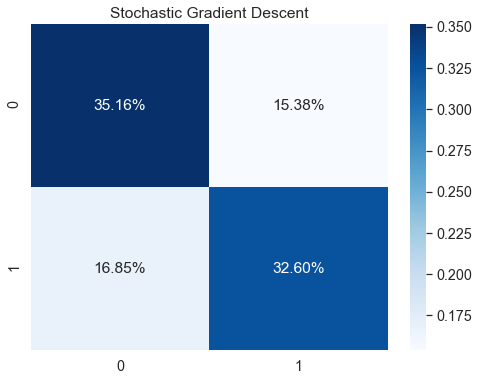

In [111]:
cm = confusion_matrix(y_test_s, y_pred)
sns.set(font_scale = 1.3)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', xticklabels=s_labels, yticklabels=s_labels)
ax.set_title('Stochastic Gradient Descent');


fig.savefig('images/matrix.png',transparent=False)

In [99]:
y_test_s

1443    0
1240    0
680     0
2348    0
12      0
       ..
1686    0
1794    0
1739    0
2715    0
564     0
Name: sentiment, Length: 713, dtype: int64

#### Random Forest Model

In [ ]:
rfc_sentiment = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('rfc', RandomForestClassifier(random_state=5)),
              ])

rfc_sentiment.fit(X_train_s, y_train_s)

rfc_params = {
    'vect__strip_accents':[None,'ascii','unicode'],
    'vect__lowercase': [True, False],
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__smooth_idf': [True, False],
    'rfc__n_estimators': [100,200,300,400,500],
    'rfc__criterion': ['gini','entropy'],
    'rfc__max_depth': [1,3,5],
    'rfc__class_weight': [None,'balanced', 'balanced_subsample']
}

rfc_gs = GridSearchCV(rfc_sentiment, param_grid= rfc_params, cv=5, verbose=1, n_jobs=-3, scoring='accuracy')

rfc_gs = rfc_gs.fit(X_train_s, y_train_s)

In [107]:
rfc_gs.best_score_ 

In [108]:
rfc_gs.best_params_

In [109]:
rfc_sentiment = Pipeline([('vect', CountVectorizer(strip_accents='ascii',ngram_range=(2,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(class_weight= 'balanced_subsample',
                                              criterion= 'gini', 
                                              max_depth=3,
                                              n_estimators = 400,
                                              random_state=5))
              ])

cv_mean, accuracy, y_pred, rfc_sentiment = et.run_model(X, y_sentiment, rfc_sentiment)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

sentiment_models_t['RFC'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}

CV Mean: 0.8064
Accuracy: 0.8177


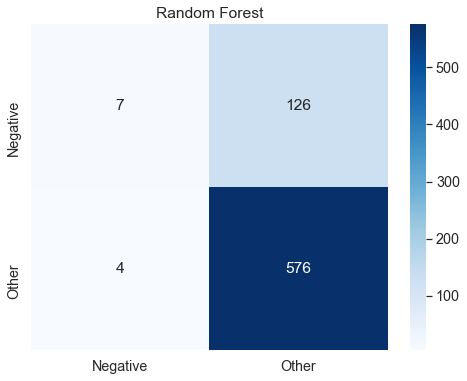

In [110]:
cm = confusion_matrix(y_test_s, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=s_labels, yticklabels=s_labels)
ax.set_title('Random Forest');

#### Naive Bayes Model

In [111]:
naive_sentiment = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('naive', MultinomialNB()),
              ])

naive_sentiment.fit(X_train_s, y_train_s)

naive_params = {
    'vect__strip_accents':[None,'ascii','unicode'],
    'vect__lowercase': [True, False],
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__smooth_idf': [True, False]

}

naive_gs = GridSearchCV(naive_sentiment, param_grid= naive_params, cv=5, verbose=1, n_jobs=-3, scoring='accuracy')

naive_gs = naive_gs.fit(X_train_s, y_train_s)

In [112]:
naive_gs.best_score_ 

In [113]:
naive_gs.best_params_

In [114]:
naive_sentiment = Pipeline([('vect', CountVectorizer(ngram_range=(1,1))),
               ('tfidf', TfidfTransformer(smooth_idf=False)),
               ('clf', MultinomialNB()),
              ])

cv_mean, accuracy, y_pred, naive_sentiment = et.run_model(X, y_sentiment, naive_sentiment)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

sentiment_models_t['Naive'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}

CV Mean: 0.8157
Accuracy: 0.8247


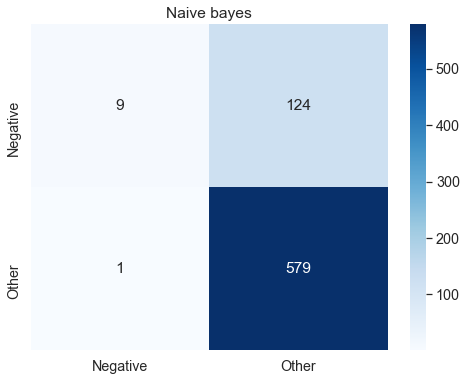

In [115]:
cm = confusion_matrix(y_test_s, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=s_labels, yticklabels=s_labels)
ax.set_title('Naive bayes');

#### Logistic Regression Model

In [116]:
lg_sentiment = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('lg', LogisticRegression(random_state=5)),
              ])

lg_sentiment.fit(X_train_s, y_train_s)

lg_params = {
    'vect__strip_accents':[None,'ascii','unicode'],
    'vect__lowercase': [True, False],
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__smooth_idf': [True, False],
    'lg__C': [1,5,10],
    'lg__solver': ['liblinear','lbfgs', 'sag', 'saga','newton-cg'],
    'lg__class_weight': ['balanced', None],
    'lg__multi_class': ['auto', 'ovr', 'multinomial'],
    'lg__penalty':['l1','l2','elasticnet', 'none']
    

}

lg_gs = GridSearchCV(lg_sentiment, param_grid= lg_params, cv=5, verbose=1, n_jobs=-3, scoring='accuracy')

lg_gs = lg_gs.fit(X_train_s, y_train_s)

In [117]:
lg_gs.best_score_ 

In [118]:
lg_gs.best_params_

In [119]:
lg_sentiment = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer(smooth_idf=False)),
               ('clf', LogisticRegression(C= 10, class_weight= None, multi_class= 'auto', penalty= 'l2', solver= 'liblinear', random_state=5)),
              ])

cv_mean, accuracy, y_pred, lg_sentiment = et.run_model(X, y_sentiment, lg_sentiment)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

sentiment_models_t['LogReg'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}


CV Mean: 0.8241
Accuracy: 0.8247


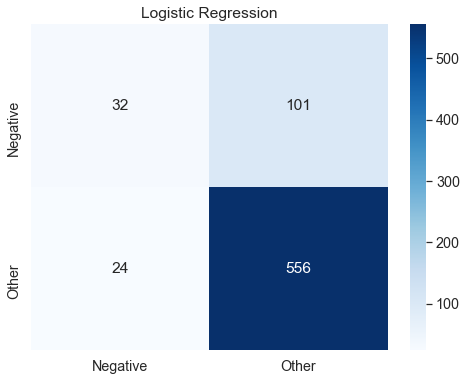

In [120]:
cm = confusion_matrix(y_test_s, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=s_labels, yticklabels=s_labels)
ax.set_title('Logistic Regression');

#### SVC Regression Model

In [163]:
svc_sentiment = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('svc', SVC(random_state=5)),
              ])

svc_sentiment.fit(X_train_s, y_train_s)

svc_params = {
    'vect__strip_accents':[None,'ascii','unicode'],
    'vect__lowercase': [True, False],
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__smooth_idf': [True, False],
    'svc__C': [1,5,10],
    'svc__kernel': ['linear','poly', 'rbf', 'sigmoid','precomputed'],
    'svc__degree': [3,6,9],
    'svc__gamma': ['auto', 'scale'],
    'svc__class_weight':[None, 'balanced']
    

}

svc_gs = GridSearchCV(svc_sentiment, param_grid= svc_params, cv=5, verbose=1, n_jobs=-3, scoring='recall')

svc_gs = svc_gs.fit(X_train_s, y_train_s)

Fitting 5 folds for each of 6480 candidates, totalling 32400 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  30 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-3)]: Done 180 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-3)]: Done 430 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-3)]: Done 780 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-3)]: Done 1330 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-3)]: Done 2080 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-3)]: Done 2930 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-3)]: Done 3680 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-3)]: Done 4600 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-3)]: Done 5640 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-3)]: Done 6880 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-3)]: Done 8080 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-3)]: Done 9430 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-3)]: Done 10780 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-3)]: Done 12320 tasks     

In [ ]:
svc_gs.best_score_ 

In [ ]:
svc_gs.best_params_

In [ ]:
svc_sentiment = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer(smooth_idf=False)),
               ('clf', SVC()),
              ])

cv_mean, accuracy, y_pred, svc_sentiment = et.run_model(X, y_sentiment, svc_sentiment)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

sentiment_models_t['SVC'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}


In [ ]:
cm = confusion_matrix(y_test_s, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=s_labels, yticklabels=s_labels)
ax.set_title('Logistic Regression');

In [121]:
sentiment_models_t 

{'SGD': {'CV Mean': 0.8227, 'Accuracy': 0.8233},
 'RFC': {'CV Mean': 0.8064, 'Accuracy': 0.8177},
 'Naive': {'CV Mean': 0.8157, 'Accuracy': 0.8247},
 'LogReg': {'CV Mean': 0.8241, 'Accuracy': 0.8247}}

### Target Models

In [304]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y_target, test_size= 0.25, random_state=5)

In [305]:
target_models_t = {}

#### Stochastic Gradient Descent Model

In [306]:
sgd_target = Pipeline([('vect', CountVectorizer()), 
               ('tfidf', TfidfTransformer()),
               ('sgd', SGDClassifier(random_state=5)),
              ])

sgd_target.fit(X_train_t, y_train_t)

sgd_params = {
    'vect__strip_accents':[None,'ascii','unicode'],
    'vect__lowercase': [True, False],
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__smooth_idf': [True, False],
    'sgd__loss': ['hinge','log','modified_huber','squared_hinge'],
    'sgd__max_iter':[1000,2000],
    'sgd__class_weight': [None, 'balanced']
}

sgd_gs = GridSearchCV(sgd_target,param_grid=sgd_params, cv=5, verbose=1, n_jobs=-3, scoring='accuracy')

sgd_gs = sgd_gs.fit(X_train_t, y_train_t)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  30 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-3)]: Done 290 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-3)]: Done 790 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-3)]: Done 1420 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-3)]: Done 2230 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-3)]: Done 2880 out of 2880 | elapsed:   56.7s finished


In [307]:
sgd_gs.best_score_

0.7422738514740966

In [308]:
sgd_gs.best_params_

{'sgd__class_weight': 'balanced',
 'sgd__loss': 'log',
 'sgd__max_iter': 1000,
 'tfidf__smooth_idf': False,
 'vect__lowercase': True,
 'vect__ngram_range': (1, 1),
 'vect__strip_accents': None}

In [309]:
sgd_target = Pipeline([('vect', CountVectorizer(ngram_range= (1,1))), 
               ('tfidf', TfidfTransformer(smooth_idf=False)),
               ('clf', SGDClassifier(loss = 'log', class_weight='balanced', random_state=5)),
              ])

cv_mean, accuracy, y_pred, sgd_target = et.run_model(X, y_target, sgd_target)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

target_models_t['SGD'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}

CV Mean: 0.7423
Accuracy: 0.7728


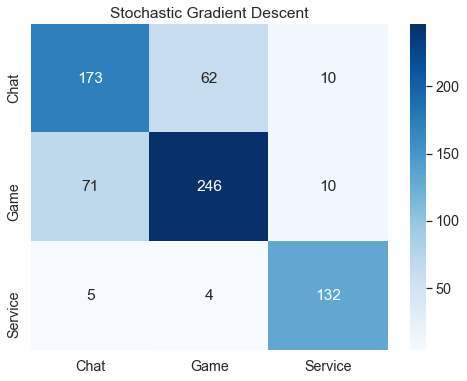

In [310]:
cm = confusion_matrix(y_test_t, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=t_labels, yticklabels=t_labels)
ax.set_title('Stochastic Gradient Descent');

#### Random Forest Model

In [311]:
rfc_target = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('rfc', RandomForestClassifier(random_state=5)),
              ])

rfc_target.fit(X_train_t, y_train_t)

rfc_params = {
    'vect__strip_accents':[None,'ascii','unicode'],
    'vect__lowercase': [True, False],
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__smooth_idf': [True, False],
    'rfc__n_estimators': [100,200,300,400,500],
    'rfc__criterion': ['gini','entropy'],
    'rfc__max_depth': [1,3,5],
    'rfc__class_weight': [None,'balanced', 'balanced_subsample']
}

rfc_gs = GridSearchCV(rfc_target, param_grid= rfc_params, cv=5, verbose=1, n_jobs=-3, scoring='accuracy')

rfc_gs = rfc_gs.fit(X_train_t, y_train_t)

Fitting 5 folds for each of 3240 candidates, totalling 16200 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  30 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-3)]: Done 180 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-3)]: Done 430 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-3)]: Done 780 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-3)]: Done 1230 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-3)]: Done 1780 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-3)]: Done 2430 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-3)]: Done 3180 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-3)]: Done 4030 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-3)]: Done 4980 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-3)]: Done 6030 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-3)]: Done 7180 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-3)]: Done 8430 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-3)]: Done 9780 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-3)]: Done 11230 tasks      

In [312]:
rfc_gs.best_score_ 

0.6309943312394668

In [313]:
rfc_gs.best_params_

{'rfc__class_weight': 'balanced_subsample',
 'rfc__criterion': 'entropy',
 'rfc__max_depth': 5,
 'rfc__n_estimators': 400,
 'tfidf__smooth_idf': False,
 'vect__lowercase': True,
 'vect__ngram_range': (1, 1),
 'vect__strip_accents': None}

In [314]:
rfc_target = Pipeline([('vect', CountVectorizer(ngram_range=(1,1))),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(class_weight= 'balanced_subsample',
                                              criterion= 'entropy', 
                                              max_depth=5,
                                              n_estimators =400,
                                              random_state=5))
              ])

cv_mean, accuracy, y_pred, rfc_target = et.run_model(X, y_target, rfc_target)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

target_models_t['RFC'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}

CV Mean: 0.6291
Accuracy: 0.6662


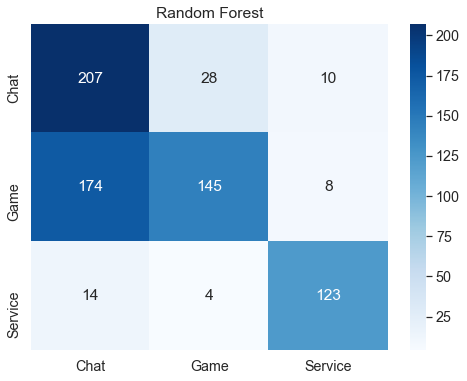

In [315]:
cm = confusion_matrix(y_test_t, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=t_labels, yticklabels=t_labels)
ax.set_title('Random Forest');

#### Naive Bayes Model

In [316]:
naive_target = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('naive', MultinomialNB()),
              ])

naive_target.fit(X_train_t, y_train_t)

naive_params = {
    'vect__strip_accents':[None,'ascii','unicode'],
    'vect__lowercase': [True, False],
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__smooth_idf': [True, False]

}

naive_gs = GridSearchCV(naive_target, param_grid= naive_params, cv=5, verbose=1, n_jobs=-3, scoring='accuracy')

naive_gs = naive_gs.fit(X_train_t, y_train_t)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-3)]: Done 180 out of 180 | elapsed:    1.6s finished


In [317]:
naive_gs.best_score_ 

0.715148066274158

In [318]:
naive_gs.best_params_

{'tfidf__smooth_idf': False,
 'vect__lowercase': True,
 'vect__ngram_range': (1, 1),
 'vect__strip_accents': None}

In [319]:
naive_target = Pipeline([('vect', CountVectorizer(ngram_range=(1,1))),
               ('tfidf', TfidfTransformer(smooth_idf=True)),
               ('clf', MultinomialNB()),
              ])

cv_mean, accuracy, y_pred, naive_target = et.run_model(X, y_target, naive_target)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

target_models_t['Naive'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}

CV Mean: 0.7142
Accuracy: 0.7377


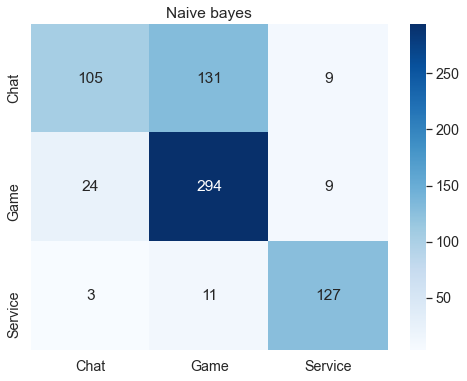

In [320]:
cm = confusion_matrix(y_test_t, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=t_labels, yticklabels=t_labels)
ax.set_title('Naive bayes');

#### Logistic Regression Model

In [1]:
lg_target = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('lg', LogisticRegression(random_state=5)),
              ])

lg_target.fit(X_train_t, y_train_t)

lg_params = {
    'vect__strip_accents':[None,'ascii','unicode'],
    'vect__lowercase': [True, False],
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__smooth_idf': [True, False],
    'lg__C': [1,5,10],
    'lg__solver': ['liblinear','lbfgs', 'sag', 'saga','newton-cg'],
    'lg__class_weight': ['balanced', None],
    'lg__multi_class': ['auto', 'ovr', 'multinomial'],
    'lg__penalty':['l1','l2','elasticnet', 'none'],
    'lg__max_iter': [100, 200, 300]
    

}

lg_gs = GridSearchCV(lg_target, param_grid= lg_params, cv=5, verbose=1, n_jobs=-3, scoring='accuracy')

lg_gs = lg_gs.fit(X_train_t, y_train_t)

NameError: name 'Pipeline' is not defined

In [141]:
lg_gs.best_score_ 

In [142]:
lg_gs.best_params_

In [143]:
lg_target = Pipeline([('vect', CountVectorizer(lowercase=True, ngram_range=(1,1))),
               ('tfidf', TfidfTransformer(smooth_idf=False)),
               ('clf', LogisticRegression(C= 5, max_iter=10000, class_weight= 'balanced', multi_class= 'auto', penalty= 'l2', solver= 'sag', random_state=5)),
              ])

cv_mean, accuracy, y_pred, lg_target = et.run_model(X, y_target, lg_target)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

target_models_t['LogReg'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}


C:\Users\edelp\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\edelp\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\edelp\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\edelp\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\edelp\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear

CV Mean: 0.6282
Accuracy: 0.6634


C:\Users\edelp\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


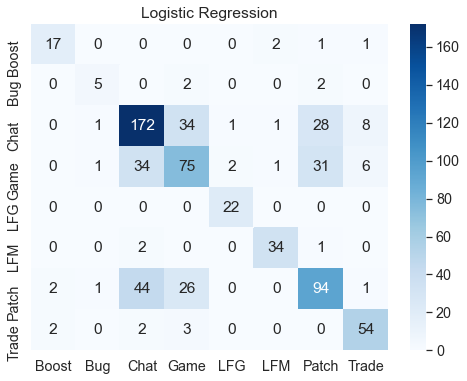

In [144]:
cm = confusion_matrix(y_test_t, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=t_labels, yticklabels=t_labels)
ax.set_title('Logistic Regression');

In [145]:
target_models_t

{'SGD': {'CV Mean': 0.6286, 'Accuracy': 0.6676},
 'RFC': {'CV Mean': 0.5388, 'Accuracy': 0.5456},
 'Naive': {'CV Mean': 0.6151, 'Accuracy': 0.6452},
 'LogReg': {'CV Mean': 0.6282, 'Accuracy': 0.6634}}

### Tuned Model Performance

In [146]:
s_t_model_df = pd.DataFrame()
s_tmp_labels = list(sentiment_models_t.keys())

In [147]:
model_list = []
cv_list = []
acc_list = []

for model_name in s_tmp_labels:
    cv_list.append(list(sentiment_models_t[model_name].values())[0])
    acc_list.append(list(sentiment_models_t[model_name].values())[1])

s_t_model_df['model'] = sentiment_models_t.keys()
s_t_model_df['cv_mean'] = cv_list
s_t_model_df['accuracy'] = acc_list

s_t_model_df

,model,cv_mean,accuracy
0,SGD,0.8227,0.8233
1,RFC,0.8064,0.8177
2,Naive,0.8157,0.8247
3,LogReg,0.8241,0.8247


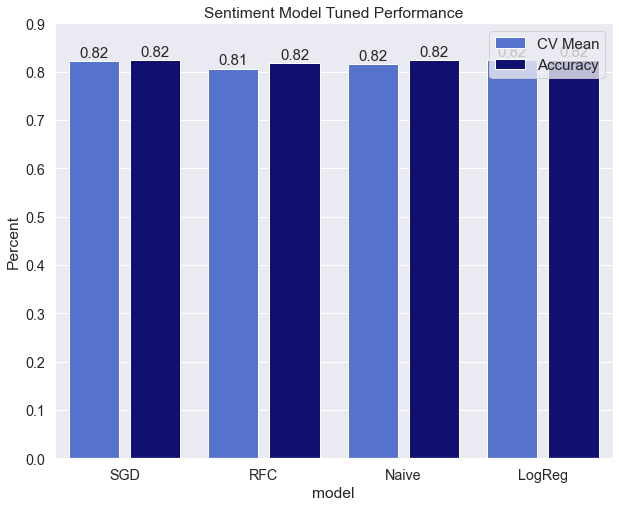

In [148]:
fig, ax = plt.subplots(figsize=(10,8))
width = .45
sns.set(font_scale = 1.3)

ax1 = sns.barplot(x='model', y='cv_mean', data=s_t_model_df, color='royalblue', label='CV Mean')

for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width)



ax2 = sns.barplot(x='model', y='accuracy', data=s_t_model_df, color='navy', label='Accuracy')

for bar in ax.containers[1]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width))
    bar.set_width(w * width)

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

ax.set_ylabel('Percent')
ax.set_ybound(upper= .9)
ax.legend(fontsize= 15)
ax.set_title('Sentiment Model Tuned Performance')


plt.show()

In [149]:
t_t_model_df = pd.DataFrame()
t_tmp_labels = list(target_models_t.keys())

In [150]:
model_list = []
cv_list = []
acc_list = []

for model_name in t_tmp_labels:
    cv_list.append(list(target_models_t[model_name].values())[0])
    acc_list.append(list(target_models_t[model_name].values())[1])

t_t_model_df['model'] = target_models_t.keys()
t_t_model_df['cv_mean'] = cv_list
t_t_model_df['accuracy'] = acc_list

t_t_model_df

,model,cv_mean,accuracy
0,SGD,0.6286,0.6676
1,RFC,0.5388,0.5456
2,Naive,0.6151,0.6452
3,LogReg,0.6282,0.6634


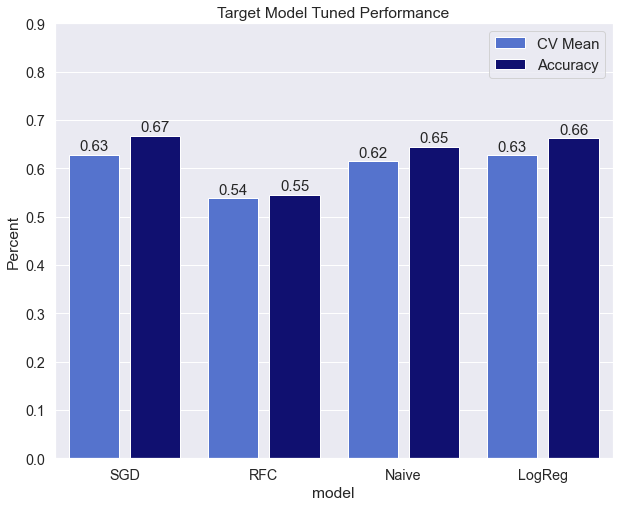

In [151]:
fig, ax = plt.subplots(figsize=(10,8))
width = .45
sns.set(font_scale = 1.3)

ax1 = sns.barplot(x='model', y='cv_mean', data=t_t_model_df, color='royalblue', label='CV Mean')

for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width)



ax2 = sns.barplot(x='model', y='accuracy', data=t_t_model_df, color='navy', label='Accuracy')

for bar in ax.containers[1]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width))
    bar.set_width(w * width)

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

ax.set_ylabel('Percent')
ax.set_ybound(upper= .9)
ax.legend(fontsize= 15)
ax.set_title('Target Model Tuned Performance')


plt.show()